<a href="https://colab.research.google.com/github/Sarvagya4/Fine_tunning_Distilbert-for-Emotion-Recognition/blob/main/Finetunning_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

In [4]:
import pandas as pd
from datasets import list_datasets

In [5]:
all_datasets = list_datasets()

<ipython-input-5-f6f3a82aff2d>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
len(all_datasets)

207049

In [7]:
'dair-ai/emotion' in all_datasets

True

In [8]:
from datasets import load_dataset

emotion = load_dataset('emotion')
emotion.set_format(type='pandas')

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
df = emotion['train'][:]

In [10]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
classes = emotion['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [12]:
df['label_name']= df['label'].apply(lambda x: classes[x])
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [13]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency of classes')

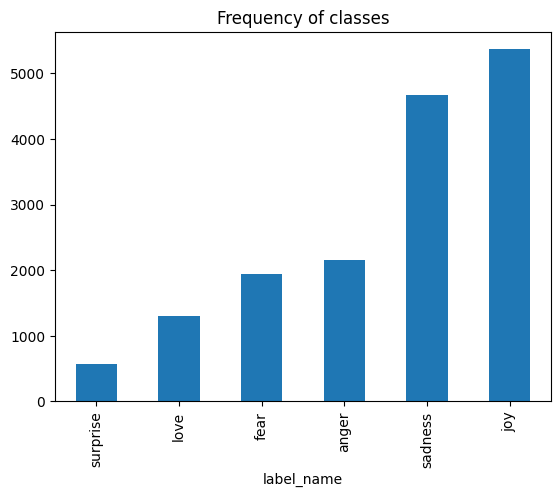

In [14]:
label_counts = df['label_name'].value_counts(ascending = True)
label_counts.plot.bar()
plt.title('Frequency of classes')

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

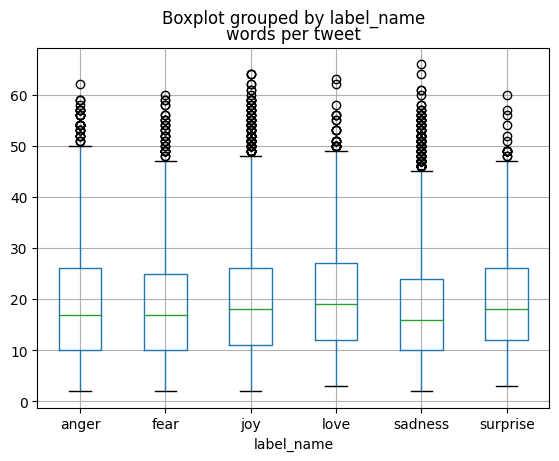

In [15]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('words per tweet' , by='label_name')

In [16]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
text = "I love machine learning!."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [18]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'love', 'machine', 'learning', '!', '.', '[SEP]']


In [19]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

In [20]:
emotion.reset_format()

In [21]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [22]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(emotion['train'][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [23]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [25]:
text

'I love machine learning!.'

In [26]:
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[ 101, 1045, 2293, 3698, 4083,  999, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [27]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [28]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [29]:
with torch.no_grad():
  outputs = model(**inputs)


last_hidden_states = outputs.last_hidden_state

In [30]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[ 0.0441,  0.0161, -0.0989,  ..., -0.0659,  0.3876,  0.3853],
         [ 0.5721,  0.2130, -0.1761,  ..., -0.0060,  0.6306,  0.3630],
         [ 0.7923,  0.7312,  0.5259,  ..., -0.1281,  0.4602,  0.1050],
         ...,
         [ 0.4746, -0.0759,  0.3871,  ...,  0.3115,  0.2394, -0.1416],
         [ 0.1792, -0.7965,  0.2458,  ...,  0.2883,  0.1094, -0.4530],
         [ 0.8794,  0.2772, -0.5124,  ...,  0.1830, -0.6160, -0.1980]]]), hidden_states=None, attentions=None)

In [31]:
last_hidden_states.shape

torch.Size([1, 8, 768])

In [32]:
from transformers import AutoModelForSequenceClassification

num_labs = len(classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labs).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
device

device(type='cuda')

In [37]:
from transformers import TrainingArguments

In [39]:
batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy= 'epoch',
                                  disable_tqdm=False)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return { 'accuracy': acc, 'f1':f1}

In [45]:
from transformers import Trainer

trainer = Trainer(model= model,
                  args= training_args,
                  compute_metrics= compute_metrics,
                  train_dataset = emotions_encoded['train'],
                  eval_dataset = emotions_encoded['validation'],
                  tokenizer=tokenizer)

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.303892,0.903000,0.902221
2,0.524000,0.212213,0.927000,0.926972


TrainOutput(global_step=500, training_loss=0.5240230712890624, metrics={'train_runtime': 251.8287, 'train_samples_per_second': 127.071, 'train_steps_per_second': 1.985, 'total_flos': 720342861696000.0, 'train_loss': 0.5240230712890624, 'epoch': 2.0})

In [48]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.21149276196956635,
 'test_accuracy': 0.9165,
 'test_f1': 0.9157469907902526,
 'test_runtime': 3.8061,
 'test_samples_per_second': 525.472,
 'test_steps_per_second': 8.408}

In [50]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [51]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.93      0.94      0.93       695
           2       0.78      0.81      0.79       159
           3       0.92      0.92      0.92       275
           4       0.89      0.90      0.89       224
           5       0.85      0.62      0.72        66

    accuracy                           0.92      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [52]:
label_counts

,count
label_name,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


In [54]:
text = 'I kill you'
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

In [55]:
logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]

(3, 'anger')